# Testing creation of GMM from posterior samples

Here I test out the creation of a two-dimensional Gaussian Mixture model from a set of posterior samples. In this case I will take the $h_0$ and $\cos{\iota}$ samples.

In [1]:
%matplotlib inline

from __future__ import print_function

import os
import sys
sys.path.append("/home/matthew/lscsoft/.virtualenvs/lalapps_knope_O2/lib/python2.7/site-packages")

# import required modules
import subprocess as sp
import numpy as np
import sklearn
from sklearn import mixture
from scipy import linalg
from scipy import stats
from collections import OrderedDict

from lalapps import pulsarpputils as pppu

import matplotlib as mpl
from matplotlib import pyplot as pl

# some matplotlib configurations
mplparams = { \
      'backend': 'Agg',
      'text.usetex': True, # use LaTeX for all text
      'axes.linewidth': 0.5, # set axes linewidths to 0.5
      'axes.grid': True, # add a grid
      'grid.linewidth': 0.5,
      'font.family': 'sans-serif',
      'font.sans-serif': 'Avant Garde, Helvetica, Computer Modern Sans serif',
      'font.size': 15 }

mpl.rcParams.update(mplparams)

In [2]:
def gmm_prior(prevpostfile, pardict, ncomps=20, taper=None, decaywidth=5.):
    """
    Create a ND Gaussian Mixture Model for use as a prior.

    This will use the BayesianGaussianMixture Model from scikit-learn, which fits a Dirichlet Process Gaussian
    Mixture Model to the input data infering the number of components required. The input to this should be
    a previously calculated posterior sample file, or numpy array of samples. If a files is given then the
    parameters given as keys in the `pardict` ordered dictionary will be extracted. For each parameter name
    key in the `pardict` ordered there should be pairs of hard upper an lower limits of the particular parameters.
    If any of these are not +/-infinity then the samples will be duplicated and reflected around that limit. This
    is to avoid edge effects for the inferred Gaussian distributions. `ncomps` sets the hyperparameter used in
    the Dirichlet process related to the number of Gaussian components.

    `taper` sets whether or not to taper-off any relfected samples, and how that tapering happens. Tapering can
    use: a 'gaussian' taper, where the half-width of the Gaussian is set by the range of the samples multiplied
    by `decaywidth`; a 'triangular' taper, which falls from one to zero over the range of the samples; an
    'exponential' taper, where the decay constant is defined by 'decaywidth' multiplied by the range of the
    samples; or, an 'elliptical' taper, where the axis of the ellipse is set by 'decaywidth' multiplied by the
    range of the samples. The default is that no tapering is applied, and it should be noted that tapering can
    still leave artifacts in the final GMM.

    The means, covariance matrices and weights of the Gaussian components will be returned, along with
    the full set of points (including reflected points) used for the estimation.

    An example of using this would be for "H0" versus "COSIOTA", in which case the `pardict` might be:
    >> pardict = OrderedDict()
    >> pardict['H0'] = [0., np.inf]
    >> pardict['COSIOTA'] = [-1., 1.]
    """

    means = None
    covs = None
    weights = None

    if not isinstance(pardict, OrderedDict):
        print('Error... Input must be an ordered dictionary')
        return means, covs, weights, None

    npars = len(pardict)
    allsamples = []

    # get samples
    try:
        if not isinstance(prevpostfile, (np.ndarray, np.generic)):
            # get samples from posterior sample hdf5 file
            if not os.path.isfile(prevpostfile):
                print("Error... previous posterior sample file '%s' does not exist" % prevpostfile, file=sys.stderr)
                return means, covs, weights, None

            possamps, B, N = pppu.pulsar_nest_to_posterior(prevpostfile)
            for par in pardict:
                allsamples.append(possamps[par.upper()].samples)
        else: # get samples fron numpy array
            if prevpostfile.shape[1] == npars:
                for i in range(npars):
                    allsamples.append(prevpostfile[:,i].reshape(len(prevpostfile), 1))
            else:
                print('Error... input numpy array does not contain correct number of parameters')
                return means, covs, weights, None
    except:
        print("Error... could not extract posterior samples from file or numpy array", file=sys.stderr)
        return means, covs, weights, None

    # reflect and duplicate samples if required for all parameters (for each reflection add to ncomp)
    allsamplesnp = np.copy(allsamples).squeeze().T
    for i, p in enumerate(pardict.keys()):
        refsamples = None
        #ncomps = ncompsu
        for lim in pardict[p]:
            if np.isfinite(lim):                
                maxp = np.max(allsamples[i])
                minp = np.min(allsamples[i])
                
                sigmap = decaywidth*(maxp-minp)
                
                dist = lim - allsamplesnp[:,i]
                
                refidxs = np.ones(len(allsamplesnp[:,i]), dtype=bool)
                # reflect about this limit (with given tapering if required)
                if taper is not None:
                    if lim > maxp:
                        deltav = allsamplesnp[:,i]+2.*dist-maxp
                    elif lim < minp:
                        deltav = minp-(allsamplesnp[:,i]+2.*dist)
                    else:
                        print("Warning... limit is inside the extent of the samples")
                        continue
    
                    probkeep = np.ones(len(allsamplesnp[:,i]))
                    if taper == 'gaussian':
                        probkeep = np.exp(-0.5*(deltav)**2/sigmap**2)
                    elif taper == 'triangular':
                        probkeep = 1.-(deltav)/(maxp-minp)
                    elif taper == 'exponential':
                        probkeep = np.exp(-(deltav)/sigmap)
                    elif taper == 'elliptical':
                        probkeep = np.zeros(len(allsamplesnp[:,i]))
                        probkeep[deltav < sigmap] = np.sqrt(1.-(deltav[deltav < sigmap]/sigmap)**2)
                    else:
                        print("Warning... unknown tapering has been set, so none will be applied")
                    
                    refidxs = (np.random.rand(len(allsamplesnp[:,i])) < probkeep).flatten()
                
                thesesamples = allsamplesnp[refidxs,:]
                thesesamples[:,i] += 2.*dist[refidxs]
                if refsamples is None:
                    refsamples = np.copy(thesesamples)
                else:
                    refsamples = np.concatenate((refsamples, thesesamples))

        # stack samples
        if refsamples is not None:
            allsamplesnp = np.concatenate((allsamplesnp, refsamples))

    # scale parameters to avoid dynamic range issues
    parscales = np.std(allsamplesnp, axis=0)
    scalesmat = np.identity(npars)*parscales
    scaledsamples = allsamplesnp/parscales
    
    # run DPGMM
    dpgmm = mixture.BayesianGaussianMixture(n_components=ncomps, covariance_type='full', tol=5e-2, max_iter=500).fit(scaledsamples)   
    
    # predict the GMM components in which the samples live
    parpred = dpgmm.predict(scaledsamples)
    
    # get the means, covariances and weights of the GMM components in which actually contain predicted samples
    means = []
    covs = []
    weights = []
    for i, (mean, covar, weight) in enumerate(zip(dpgmm.means_, dpgmm.covariances_, dpgmm.weights_)):
        if np.any(parpred == i): # check if any samples predicted to be in component i
            # check that mode is within 3.5 sigma of limits otherwise don't include it
            outlims = 0
            for (mus, sigs, lowlim, highlim) in zip(mean*parscales, parscales*np.sqrt(np.diag(covar)), [pardict[p][0] for p in pardict], [pardict[p][1] for p in pardict]):
                if mus < lowlim - 3.*sigs or mus > highlim + 3.*sigs:
                    outlims += 1

            if outlims == 2:
                continue

            # rescale to get back to true values
            means.append(mean*parscales)
            covs.append(np.dot(scalesmat, np.dot(covar, scalesmat)))
            weights.append(weight)

    if len(means) == 0:
        print("Error... no GMM components returned", file=sys.stderr)
    
    return means, covs, weights, allsamplesnp

In [12]:
# run lalapps_pulsar_parameter_estimation on some simulated noise and convert the output to posterior samples
rundir = '.'
if not os.path.isdir(rundir): # make the directory
    os.makedirs(rundir)

detector = 'H1'        # the detector to use
psrname = 'J0000+0000' # a fake pulsar name

# set the output directory
outdir = os.path.join(rundir, 'output')
if not os.path.isdir(outdir):
    os.makedirs(outdir)

# set the executables (this assumes that you are using virtual environments with virtualenvwrapper.sh and
# have a WORKON_HOME environment variable set, but you can change the path as required)
virenv = 'lalapps_knope_O2' # name of your virtual environment
execpath = os.path.join(os.environ['WORKON_HOME'], virenv)
execpath = os.path.join(execpath, 'bin')

ppenexec = os.path.join(execpath, 'lalapps_pulsar_parameter_estimation_nested')
n2pexec = os.path.join(execpath, 'lalapps_nest2pos') # script to convert nested samples to posterior samples

# create par file
pardat = """PSRJ J0000+0000
RAJ 00:00:00.0
DECJ 00:00:00.0
F0 123.4567890
PEPOCH 56789.0
EPHEM DE405
"""

parfile = os.path.join(rundir, 'pulsar.par')
fp = open(parfile, 'w')
fp.write(pardat)
fp.close()

# create the prior file for the lalapps_pulsar_parameter_estimation_nested code
priorfile = os.path.join(rundir, 'pulsar.prior')
priordat = """H0 uniform 0 1e-20
PHI0 uniform 0 {}
PSI uniform {} {}
COSIOTA uniform -1 1
"""
fp = open(priorfile, 'w')
fp.write(priordat.format(np.pi, 0., np.pi/2.))
fp.close()

Nlive = 2048 # number of live points

# run lalapps_pulsar_parameter_estimation_nested
codecall = ' '.join([ppenexec, '--fake-data', detector, '--par-file', parfile, '--prior-file', priorfile,
                     '--outfile', os.path.join(outdir, 'fake_nest.hdf'),
                     '--Nlive', str(Nlive), '--Nmcmcinitial', '0'])

p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# nested samples need to be converted to posterior samples with lalapps_nest2pos
if os.path.isfile(os.path.join(outdir, 'fake_post.hdf')):
    os.remove(os.path.join(outdir, 'fake_post.hdf'))
codecall = ' '.join([n2pexec, '-p', os.path.join(outdir, 'fake_post.hdf'),
                     os.path.join(outdir, 'fake_nest.hdf')])
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

In [13]:
# set previous posterior file
postfile = os.path.join(outdir, 'fake_post.hdf')

# number of components hyperparameter
ncomp = 20

# parameters and their limits
pardict = OrderedDict()
pardict['h0'] = [0., np.inf]
pardict['cosiota'] = [-1., 1.]

# create GMM
means, covs, weights, samples = gmm_prior(postfile, pardict, ncomps=ncomp, taper='elliptical', decaywidth=1.0)

Read columns ['COSIOTA', 'H0', 'PHI0', 'PSI', 'deltalogL', 'deltaloglH1', 'logL', 'logPrior', 'logw', 'C22', 'CGW', 'F0', 'PHI0VECTOR', 'PHI22', 'PEPOCH', 'FREQNUM', 'PHI21', 'C21', 'DEC', 'PMRA', 'HPLUS', 'I31', 'Q22', 'HSCALARL', 'POSEPOCH', 'DIST', 'I21', 'PSITENSOR', 'IOTA', 'HSCALARB', 'PHI0TENSOR', 'HCROSS', 'PMDEC', 'COSTHETA', 'PX', 'RA', 'df', 'THETA', 'PSIVECTOR', 'F0_FIXED', 'HVECTORY', 'HVECTORX', 'PHI0SCALAR', 'PSISCALAR', 'LAMBDA']


Read columns ['COSIOTA', 'H0', 'PHI0', 'PSI', 'deltalogL', 'deltaloglH1', 'logL', 'logPrior', 'logw', 'C22', 'CGW', 'F0', 'PHI0VECTOR', 'PHI22', 'PEPOCH', 'FREQNUM', 'PHI21', 'C21', 'DEC', 'PMRA', 'HPLUS', 'I31', 'Q22', 'HSCALARL', 'POSEPOCH', 'DIST', 'I21', 'PSITENSOR', 'IOTA', 'HSCALARB', 'PHI0TENSOR', 'HCROSS', 'PMDEC', 'COSTHETA', 'PX', 'RA', 'df', 'THETA', 'PSIVECTOR', 'F0_FIXED', 'HVECTORY', 'HVECTORX', 'PHI0SCALAR', 'PSISCALAR', 'LAMBDA']


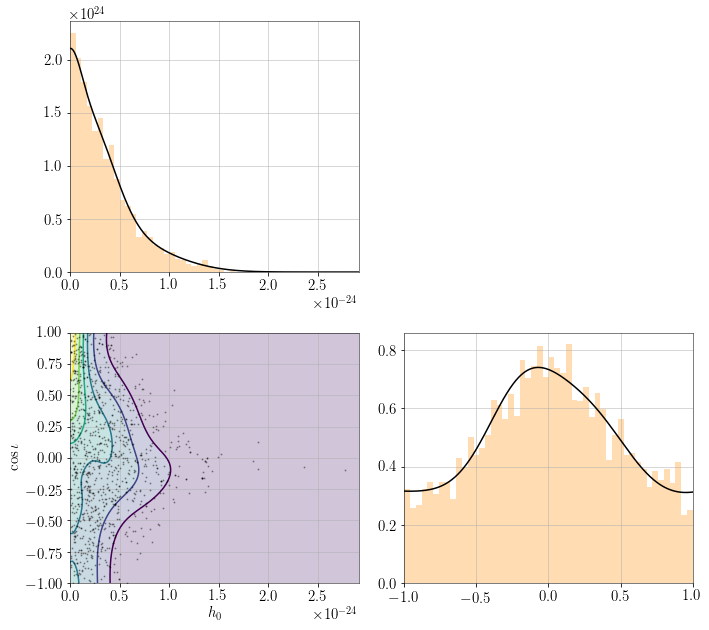

In [14]:
samples0, evsig, evnoise = pppu.pulsar_nest_to_posterior(postfile)

# plot samples and GMM
fig, axs = pl.subplots(2,2, figsize=(10,9))

axs[0][0].hist(samples0['H0'].samples, bins=50, normed=True, histtype='stepfilled', alpha=0.3, facecolor='darkorange', edgecolor='none')
axs[1][1].hist(samples0['COSIOTA'].samples, bins=50, normed=True, histtype='stepfilled', alpha=0.3, facecolor='darkorange', edgecolor='none')
axs[1][0].plot(samples0['H0'].samples[::4], samples0['COSIOTA'].samples[::4], '.', alpha=0.3, color='black', markersize=2)
axs[0][1].axis('off')

# overplot expected GMM pdfs
def gmmpdf(x, means, sigmas, weights, pidx):
    gp = np.zeros(len(x))
    for i in range(len(means)):
        mu = means[i][pidx]
        sig = sigmas[i][pidx]
        weight = weights[i]
        rv = stats.norm(loc=mu, scale=sig) # create mode
        gp += weight*rv.pdf(x) # weight each mode

    # re-normalise
    return gp/np.trapz(gp, x)

# get standard deviations for each mode
sigmas = []
for cov in covs:
    sigmas.append(np.sqrt(np.diag(cov)))

h0lims = axs[0][0].get_xlim()
h0s = np.linspace(0., h0lims[1], 1000)
pdfh0 = gmmpdf(h0s, means, sigmas, weights, 0)
axs[0][0].plot(h0s, pdfh0, 'k', lw=1.5)

cis = np.linspace(-1., 1., 1000)
pdfh0 = gmmpdf(cis, means, sigmas, weights, 1)
axs[1][1].plot(cis, pdfh0, 'k', lw=1.5)

# create determinants of covariance matrices and inverses of correlation matrices
logdets = []
invcor = []
for i in range(len(covs)):
    invsigmamat = np.identity(2)/sigmas[i]
    invcor.append(np.linalg.inv(np.dot(invsigmamat, np.dot(covs[i], invsigmamat))))
    logdets.append(np.log(np.linalg.det(covs[i])))

# create grid image of Gaussians
imgrid = np.ones((150,150))*-np.inf
h0grid = np.linspace(h0lims[0], h0lims[1], 150)
cigrid = np.linspace(-1., 1., 150)

for i in range(len(h0grid)):
    for j in range(len(cigrid)):
        for k in range(len(covs)):
            vals = (np.array([h0grid[i],cigrid[j]])-means[k])/sigmas[k]
            tmplike = -0.5*(np.dot(vals, np.dot(invcor[k], vals)))
            tmplike += np.log(weights[k])
            tmplike -= (0.5*2.*(np.log(np.pi) + np.log(2.)) + logdets[k])
            imgrid[i,j] = np.logaddexp(imgrid[i,j], tmplike)

imgrid = np.exp(imgrid-np.amax(imgrid))
 
# show 2D image of GMM
axs[1][0].contour(imgrid.T, extent=[h0lims[0], h0lims[1], -1., 1.], cmap='viridis', lw=2)
axs[1][0].contourf(imgrid.T, extent=[h0lims[0], h0lims[1], -1., 1.], cmap='viridis', alpha=0.25)

axs[0][0].set_xlim([0., h0lims[1]])
axs[1][0].set_xlim([0., h0lims[1]])
axs[1][0].set_xlabel('$h_0$')
axs[1][0].set_ylim([-1., 1.])
axs[1][0].set_ylabel('$\cos{\iota}$')
axs[1][1].set_xlim([-1., 1.])
pl.tight_layout()

In [18]:
# create new prior based on GMM and re-run on new simulated data
priorfilenew = os.path.join(rundir, 'pulsargmm.prior')
priordat = """{}
PHI0 uniform 0 {}
PSI uniform {} {}
"""
gmmprior = "H0:COSIOTA %d " % len(means)
gmmprior += '[' + ','.join(['['+','.join([str(v) for v in vs.tolist()])+']' for vs in means]) + '] '
gmmprior += '[' + ','.join(['['+','.join(['['+','.join([str(ca) for ca in c])+']' for c in cs.tolist()])+']' for cs in covs]) + '] '
gmmprior += '[' +  ','.join([str(w) for w in weights]) + '] '
# write out limits for each parameter in turn
for gp in pardict:
    gmmprior += '[' + ','.join([str(lim) for lim in pardict[gp]]) + '] '

fp = open(priorfilenew, 'w')
fp.write(priordat.format(gmmprior, np.pi, 0., np.pi/2.))
fp.close()

# run lalapps_pulsar_parameter_estimation_nested
codecall = ' '.join([ppenexec, '--fake-data', detector, '--par-file', parfile, '--prior-file', priorfilenew,
                     '--outfile', os.path.join(outdir, 'fake_nest_gmmprior.hdf'),
                     '--Nlive', str(Nlive), '--Nmcmcinitial', '0'])

p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# nested samples need to be converted to posterior samples with lalapps_nest2pos
if os.path.isfile(os.path.join(outdir, 'fake_post_gmmprior.hdf')):
    os.remove(os.path.join(outdir, 'fake_post_gmmprior.hdf'))
codecall = ' '.join([n2pexec, '-p', os.path.join(outdir, 'fake_post_gmmprior.hdf'),
                     os.path.join(outdir, 'fake_nest_gmmprior.hdf')])
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

In [20]:
samples1, evsig, evnoise = pppu.pulsar_nest_to_posterior(os.path.join(outdir, 'fake_post_gmmprior.hdf'))

# plot samples and GMM
fig, axs = pl.subplots(2,2, figsize=(10,9))

axs[0][0].hist(samples1['H0'].samples, bins=50, normed=True, histtype='stepfilled', alpha=0.3, facecolor='darkorange', edgecolor='none')
axs[1][1].hist(samples1['COSIOTA'].samples, bins=50, normed=True, histtype='stepfilled', alpha=0.3, facecolor='darkorange', edgecolor='none')
axs[1][0].plot(samples1['H0'].samples[::4], samples0['COSIOTA'].samples[::4], '.', alpha=0.3, color='black', markersize=2)
axs[0][1].axis('off')

h0lims = axs[0][0].get_xlim()
h0s = np.linspace(0., h0lims[1], 1000)
pdfh0 = gmmpdf(h0s, means, sigmas, weights, 0)
axs[0][0].plot(h0s, pdfh0, 'k', lw=1.5)

cis = np.linspace(-1., 1., 1000)
pdfh0 = gmmpdf(cis, means, sigmas, weights, 1)
axs[1][1].plot(cis, pdfh0, 'k', lw=1.5)

# show 2D image of GMM
axs[1][0].contour(imgrid.T, extent=[h0lims[0], h0lims[1], -1., 1.], cmap='viridis', lw=2)
axs[1][0].contourf(imgrid.T, extent=[h0lims[0], h0lims[1], -1., 1.], cmap='viridis', alpha=0.25)

axs[0][0].set_xlim([0., h0lims[1]])
axs[1][0].set_xlim([0., h0lims[1]])
axs[1][0].set_xlabel('$h_0$')
axs[1][0].set_ylim([-1., 1.])
axs[1][0].set_ylabel('$\cos{\iota}$')
axs[1][1].set_xlim([-1., 1.])
pl.tight_layout()

IOError: Unable to open file (Unable to open file: name = './output/fake_post_gmmprior.hdf', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [21]:
err

'Traceback (most recent call last):\n  File "/home/matthew/lscsoft/.virtualenvs/lalapps_knope_O2/bin/lalapps_nest2pos", line 281, in <module>\n    return_values = read_nested_from_hdf5(datafiles)\n  File "/home/matthew/lscsoft/.virtualenvs/lalapps_knope_O2/bin/lalapps_nest2pos", line 110, in read_nested_from_hdf5\n    log_noise_evidence = reduce(logaddexp, log_noise_evidences) - log(len(log_noise_evidences))\nTypeError: reduce() of empty sequence with no initial value\n'